# From data to knowledge

We start by importing the necessary libraries.

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

### Simulating voters

For this simulation we already know the truth how every voter in the country is going to vote. We will create a dataset with the preference for each voter. For simplicity, we choose the first 450'000 voters to vote for candidate 0 and the other 550'000 voters to vote for candidate 1. 

In [112]:
all_votes = pd.DataFrame(
  {'Vote': np.concatenate([np.zeros(450_000), np.ones(550_000) ])}
)


We already know the the proportions of voters that vote for candidate 1 can be calculated by computing the mean of the dataset.

In [113]:
print("the proportions of the votes for candidate 1 is", all_votes['Vote'].mean())

the proportions of the votes for candidate 1 is 0.55


### Simulating a poll

We can simulate a poll by taking a random sample of the voters. We will take a sample of 1000 voters and calculate the proportion of voters that vote for candidate 1.



In [114]:
sample_size = 1000
sample = all_votes.sample(sample_size)
print("the proportions of the votes for candidate 1 in the sample is", sample['Vote'].mean())

the proportions of the votes for candidate 1 in the sample is 0.539


The following shows a visualization that displayes the proportion of voters that vote for candidate 1 in the population and the proportion of voters that vote for candidate 1 in the sample. for the true population (blue bar) and the sample (orange bar).

<Axes: xlabel='Vote', ylabel='Proportion'>

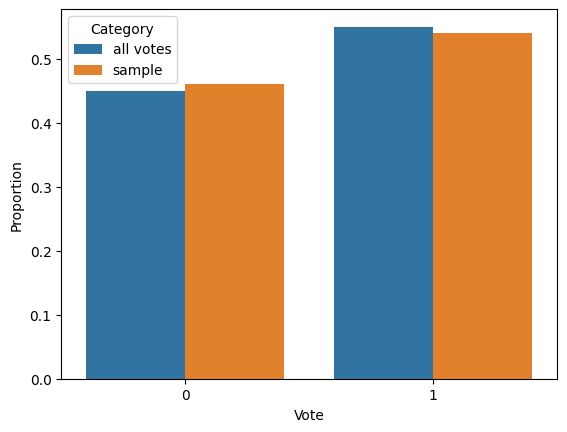

In [115]:
sample = all_votes.sample(sample_size)

prop_ones_all_votes = all_votes['Vote'].mean()
prop_zeros_all_votes = 1 - all_votes['Vote'].mean()

prop_ones_samples = sample['Vote'].mean()
prop_zeros_sample = 1 - sample['Vote'].mean()


df = pd.DataFrame(
    {
        "Category": ["all votes", "sample", "all votes", "sample"],
        "Vote": [0, 0, 1, 1],
        "Proportion": [prop_zeros_all_votes, prop_zeros_sample, prop_ones_all_votes, prop_ones_samples]
    }
)
df
sns.barplot(data=df, x="Vote", y ="Proportion", hue="Category", orient='v')


#### Exercise

* Repeat the experiment a couple of times. Does the sample proportion always match the population proportion?
* What changes when you increase or decrease the sample size?

The following code simulates `num_polls` polls and keeps track of the estimates for the proportion of voters that vote for candidate 1. It then displays the estimates in a plot (a histogram).

<Axes: ylabel='Count'>

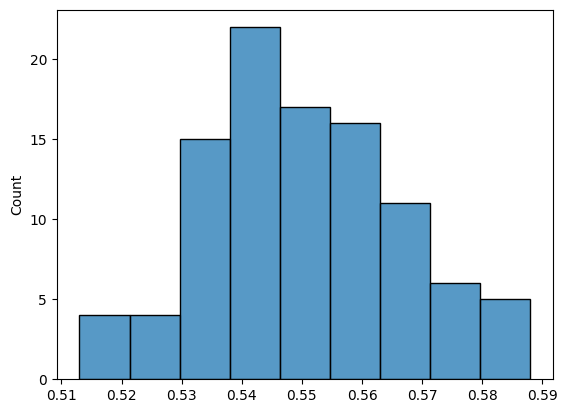

In [116]:
num_polls = 100

p_estimates = np.zeros(num_polls) # keeps track of the proportions

for i in range(0, num_polls): # repeat many times  
  sample = all_votes.sample(sample_size)  # take a sample
  p_estimates[i] = sample['Vote'].mean()  # estimate the proportion

sns.histplot(p_estimates)   # plot the histogram


#### Exercise:

- What can you observe about the proportions of voters when you increase the sample size?
- What can you observe about the proportions of voters when you decrease the sample size?
- What can you say about the shape of the histogram that is plotted when you increase the number of polls?

### 

### Bootstrapping

In practice, we don't control the data generating process and cannot generate arbitrary samples. We can, however, exploit the fact that for large enough samples, the proportion of 0 votes in the samples is very close to the proportion of 0 votes in the full population. 

We can use this fact to estimate the uncertainty of our estimate. We can do this by resampling from the sample we have and calculating the proportion of 0 votes in the resampled data. This is called bootstrapping.

Let's start with some sample.

In [117]:
sample = all_votes.sample(sample_size, replace=False)

Next we will resample from the sample with replacement and calculate the quantities of interest. We will repeat this process `num_resamples` times.

<Axes: ylabel='Density'>

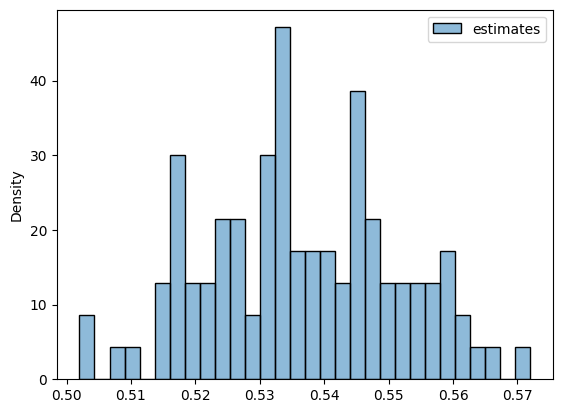

In [121]:
bootstrap_ps = []


# Generate bootstrap samples and compute mean
bootstrap_estimates = pd.DataFrame({"estimates" : []})

num_resamples = 100

for i in range(0, num_resamples):
  bootstrap_sample = sample.sample(n=len(sample), replace=True)
  estimate = bootstrap_sample.mean()

  bootstrap_estimates = pd.concat([bootstrap_estimates, pd.DataFrame({"estimates" : estimate})])


sns.histplot(bootstrap_estimates, bins=30, stat="density")


### Confidence intervals

We can use the bootstrapped estimates to calculate a confidence interval for the proportion of voters that vote for candidate 1. The confidence interval is a range of values that is likely to contain the true proportion of voters that vote for candidate 1. 

Assuming we have 100 bootstrapped estimates, the 90% confidence interval is the interval that contains the middle 90 estimates. That is, we discard the 5 lowest and the 5 highest estimates.

This is implemented in the following code. 

the true proportion p is between 0.514 and 0.5601 with 90% confidence


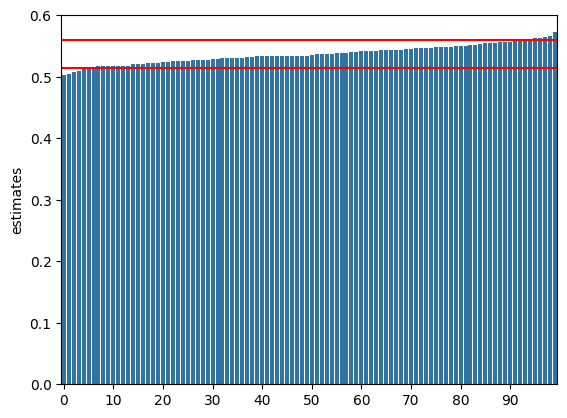

In [122]:
sorted_estimates = bootstrap_estimates.sort_values(by="estimates", inplace=False)
sns.barplot(data=sorted_estimates, x=range(0, len(sorted_estimates)), y='estimates')
plt.xticks(range(0, len(sorted_estimates), 10))

lower_bound = sorted_estimates.quantile(0.05).item() # returns value at 5th percentile
upper_bound = sorted_estimates.quantile(0.95).item() # returns value at 95th percentile

plt.axhline(lower_bound, color='red')
plt.axhline(upper_bound, color='red')


print("the true proportion p is between", lower_bound, "and", upper_bound, "with 90% confidence")


### P-Value

Confidence intervals are a way to quantify the uncertainty of our estimate. Another way to quantify the uncertainty is to calculate the probability of observing the estimate we have given that the true proportion of voters that vote for candidate 1 is 0.5. This probability is called the p-value.

It is easy to obtain the p-value by simulation. We assume that the true proportion of voters that vote for candidate 1 is 0.5. 

In [123]:
all_votes_H0 = pd.DataFrame(
  {'Vote': np.concatenate([np.zeros(500_000), np.ones(500_000) ])}
)

Now we sample again polls from this 50-50 population and calculate the proportion of voters that vote for candidate 1. We repeat this process `num_polls` times. The histogram shows the distribution of the estimates.

<Axes: ylabel='Count'>

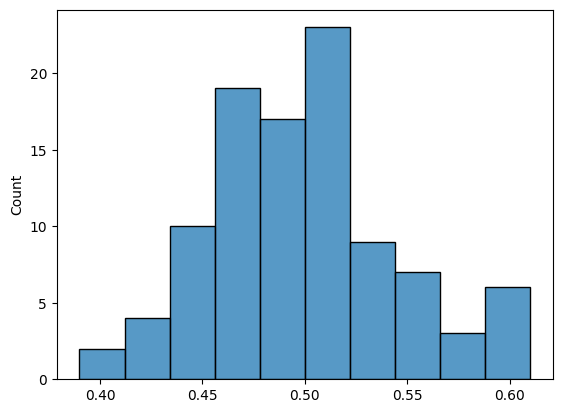

In [153]:
sample_size = 100
num_polls = 100
p_estimates_H0 = np.zeros(num_polls)
for i in range(0, num_polls):
  sample = all_votes_H0.sample(sample_size)
  p_estimates_H0[i] = sample['Vote'].mean()

sns.histplot(p_estimates_H0)

The histogram already gives us a good overview of how large proportions we would expect to see if the true proportion of voters that vote for candidate 1 is 0.5.

Now we compare it to the proportion we obtain from a sample from the true distribution.

In [157]:
p_estimate = all_votes.sample(sample_size).mean()
print("we estimated the proportion of voters that vote for candidate 1 to be", p_estimate.item())

we estimated the proportion of voters that vote for candidate 1 to be 0.52


The p-value is the proportion of estimates that are larger than the estimate we obtained from the sample.

In [160]:
# count the nubmer of outcomes on p_estimates_H0 that are greater than p_estimated
p_value = len(p_estimates_H0[(p_estimates_H0 > p_estimate.item())]) / len(p_estimates_H0)
print(p_value)

0.25


### Experiment

- Is it likely, that the estimate we obtained from the sample is from a population where the proportion of voters that vote for candidate 1 is 0.5, according to the computed p-value?
- How does the p-value change when you increase the sample size?
